In [1]:
import abacus_cosmos.Halos as ach
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import glob
from collections import Counter
import scipy.ndimage as scpimg

%matplotlib inline

In [30]:
div = {}
div[200] = np.load("../data/AbacusCosmos_1100box_00_FoF_halos_z0.300/fields/div_box_1100.0_sigmacut_200.0_cell_10.0_smooth_1.0.npy")
div[300] = np.load("../data/AbacusCosmos_1100box_00_FoF_halos_z0.300/fields/div_box_1100.0_sigmacut_300.0_cell_10.0_smooth_1.0.npy")
div[400] = np.load("../data/AbacusCosmos_1100box_00_FoF_halos_z0.300/fields/div_box_1100.0_sigmacut_400.0_cell_10.0_smooth_1.0.npy")

water = {}
water[200] = np.load("../data/AbacusCosmos_1100box_00_FoF_halos_z0.300/fields/watershed_box_1100.0_sigmacut_200.0_cell_10.0_smooth_1.0.npy")
water[300] = np.load("../data/AbacusCosmos_1100box_00_FoF_halos_z0.300/fields/watershed_box_1100.0_sigmacut_300.0_cell_10.0_smooth_1.0.npy")
water[400] = np.load("../data/AbacusCosmos_1100box_00_FoF_halos_z0.300/fields/watershed_box_1100.0_sigmacut_400.0_cell_10.0_smooth_1.0.npy")

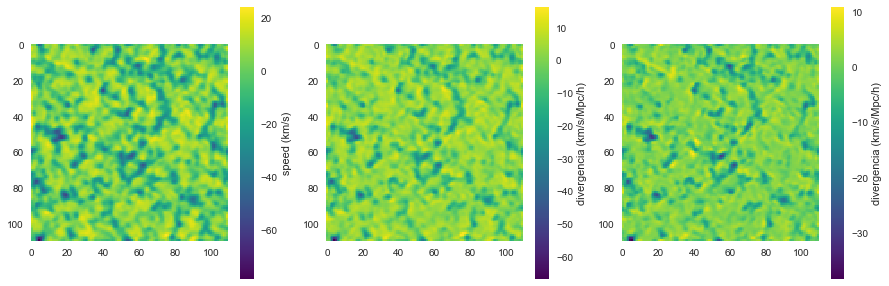

In [31]:
z_slice = 10
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(div[200][z_slice,:,:], cmap='viridis')
plt.grid(False)
plt.colorbar(label='speed (km/s)')


plt.subplot(1,3,2)
plt.imshow(div[300][z_slice,:,:], cmap='viridis')
plt.grid(False)
plt.colorbar(label='divergencia (km/s/Mpc/h)')


plt.subplot(1,3,3)
plt.imshow(div[400][z_slice,:,:], cmap='viridis')
plt.grid(False)
plt.colorbar(label='divergencia (km/s/Mpc/h)')

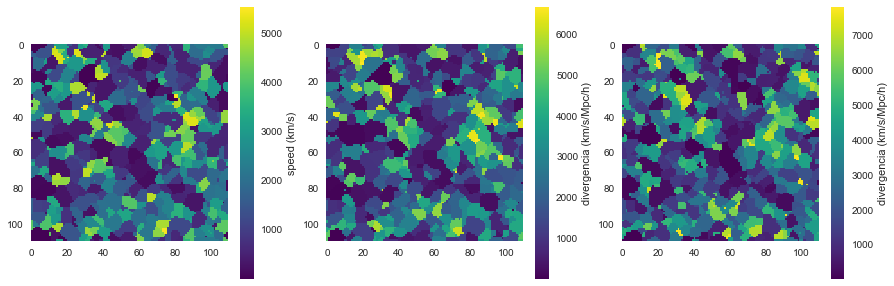

In [32]:
z_slice = 10
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(water[200][z_slice,:,:], cmap='viridis')
plt.grid(False)
plt.colorbar(label='speed (km/s)')


plt.subplot(1,3,2)
plt.imshow(water[300][z_slice,:,:], cmap='viridis')
plt.grid(False)
plt.colorbar(label='divergencia (km/s/Mpc/h)')


plt.subplot(1,3,3)
plt.imshow(water[400][z_slice,:,:], cmap='viridis')
plt.grid(False)
plt.colorbar(label='divergencia (km/s/Mpc/h)')

94


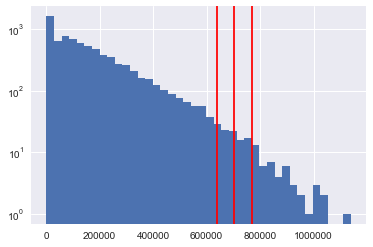

In [33]:
L_cell = 10.0
volume_laniakea = 4*((180*0.7/2))**3
f = water[400].flatten()
f = f[f!=-1]
c = Counter(f)
vol = np.array(list(c.values()))*L_cell**3

_= plt.hist(vol, log=True, bins=40)

volume_laniakea = 4*((160*0.7/2))**3
plt.axvline(x=volume_laniakea, color='red')
volume_laniakea_min = 4*((155*0.7/2))**3
plt.axvline(x=volume_laniakea_min, color='red')
volume_laniakea_max = 4*((165*0.7/2))**3
plt.axvline(x=volume_laniakea_max, color='red')

n_laniakea = np.count_nonzero((vol<volume_laniakea_max) & (vol>volume_laniakea_min))
print(n_laniakea)

94


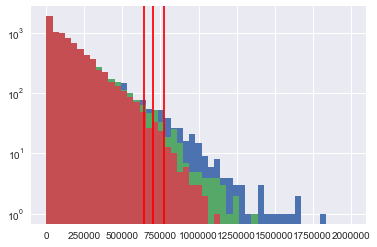

In [34]:
L_cell = 10.0
volume_laniakea = 4*((180*0.7/2))**3

f = water[200].flatten()
f = f[f!=-1]
c = Counter(f)
vol_a = np.array(list(c.values()))*L_cell**3



f = water[300].flatten()
f = f[f!=-1]
c = Counter(f)
vol_b = np.array(list(c.values()))*L_cell**3


f = water[400].flatten()
f = f[f!=-1]
c = Counter(f)
vol_c = np.array(list(c.values()))*L_cell**3


_= plt.hist(vol_a, log=True, bins=np.linspace(1,2E6,50))
_= plt.hist(vol_b, log=True, bins=np.linspace(1,2E6,50))
_= plt.hist(vol_c, log=True, bins=np.linspace(1,2E6,50))


volume_laniakea = 4*((160*0.7/2))**3
plt.axvline(x=volume_laniakea, color='red')
volume_laniakea_min = 4*((155*0.7/2))**3
plt.axvline(x=volume_laniakea_min, color='red')
volume_laniakea_max = 4*((165*0.7/2))**3
plt.axvline(x=volume_laniakea_max, color='red')

n_laniakea = np.count_nonzero((vol<volume_laniakea_max) & (vol>volume_laniakea_min))
print(n_laniakea)

In [35]:
div[1] = np.load("../data/AbacusCosmos_1100box_00_FoF_halos_z0.300/fields/div_box_1100.0_sigmacut_200.0_cell_10.0_smooth_1.0.npy")
div[2] = np.load("../data/AbacusCosmos_1100box_00_FoF_halos_z0.300/fields/div_box_1100.0_sigmacut_200.0_cell_5.0_smooth_2.0.npy")
div[4] = np.load("../data/AbacusCosmos_1100box_00_FoF_halos_z0.300/fields/div_box_1100.0_sigmacut_200.0_cell_2.5_smooth_4.0.npy")

water[1] = np.load("../data/AbacusCosmos_1100box_00_FoF_halos_z0.300/fields/watershed_box_1100.0_sigmacut_200.0_cell_10.0_smooth_1.0.npy")
water[2] = np.load("../data/AbacusCosmos_1100box_00_FoF_halos_z0.300/fields/watershed_box_1100.0_sigmacut_200.0_cell_5.0_smooth_2.0.npy")
water[4] = np.load("../data/AbacusCosmos_1100box_00_FoF_halos_z0.300/fields/watershed_box_1100.0_sigmacut_200.0_cell_2.5_smooth_4.0.npy")

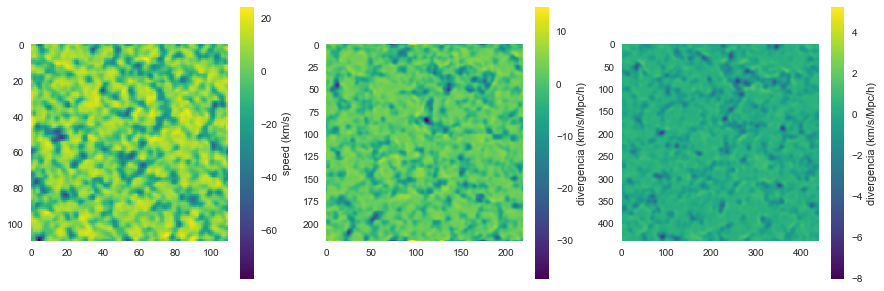

In [36]:
z_slice = 10
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(div[1][z_slice,:,:], cmap='viridis')
plt.grid(False)
plt.colorbar(label='speed (km/s)')


plt.subplot(1,3,2)
plt.imshow(div[2][z_slice,:,:], cmap='viridis')
plt.grid(False)
plt.colorbar(label='divergencia (km/s/Mpc/h)')


plt.subplot(1,3,3)
plt.imshow(div[4][z_slice,:,:], cmap='viridis')
plt.grid(False)
plt.colorbar(label='divergencia (km/s/Mpc/h)')

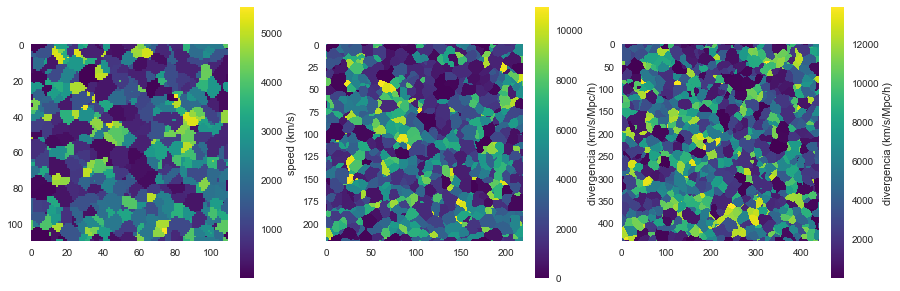

In [40]:
z_slice = 10
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(water[1][z_slice,:,:], cmap='viridis')
plt.grid(False)
plt.colorbar(label='speed (km/s)')


plt.subplot(1,3,2)
plt.imshow(water[2][z_slice,:,:], cmap='viridis')
plt.grid(False)
plt.colorbar(label='divergencia (km/s/Mpc/h)')


plt.subplot(1,3,3)
plt.imshow(water[4][z_slice,:,:], cmap='viridis')
plt.grid(False)
plt.colorbar(label='divergencia (km/s/Mpc/h)')

156


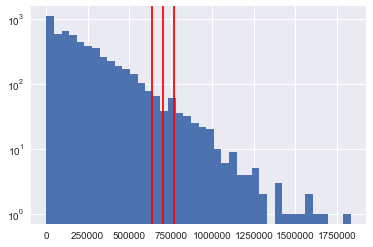

In [37]:
L_cell = 10.0
volume_laniakea = 4*((180*0.7/2))**3

f = water[1].flatten()
f = f[f!=-1]
c = Counter(f)
vol = np.array(list(c.values()))*L_cell**3

_= plt.hist(vol, log=True, bins=40)

volume_laniakea = 4*((160*0.7/2))**3
plt.axvline(x=volume_laniakea, color='red')
volume_laniakea_min = 4*((155*0.7/2))**3
plt.axvline(x=volume_laniakea_min, color='red')
volume_laniakea_max = 4*((165*0.7/2))**3
plt.axvline(x=volume_laniakea_max, color='red')

n_laniakea = np.count_nonzero((vol<volume_laniakea_max) & (vol>volume_laniakea_min))
print(n_laniakea)

156


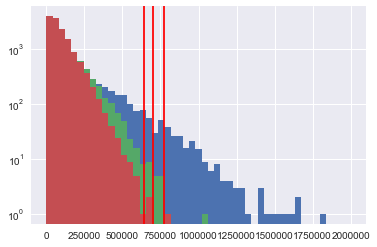

In [39]:
L_cell = 10.0
volume_laniakea = 4*((180*0.7/2))**3

f = water[1].flatten()
f = f[f!=-1]
c = Counter(f)
vol_a = np.array(list(c.values()))*L_cell**3


L_cell = 5.0
f = water[2].flatten()
f = f[f!=-1]
c = Counter(f)
vol_b = np.array(list(c.values()))*L_cell**3

L_cell = 2.5
f = water[4].flatten()
f = f[f!=-1]
c = Counter(f)
vol_c = np.array(list(c.values()))*L_cell**3


_= plt.hist(vol_a, log=True, bins=np.linspace(1,2E6,50))
_= plt.hist(vol_b, log=True, bins=np.linspace(1,2E6,50))
_= plt.hist(vol_c, log=True, bins=np.linspace(1,2E6,50))


volume_laniakea = 4*((160*0.7/2))**3
plt.axvline(x=volume_laniakea, color='red')
volume_laniakea_min = 4*((155*0.7/2))**3
plt.axvline(x=volume_laniakea_min, color='red')
volume_laniakea_max = 4*((165*0.7/2))**3
plt.axvline(x=volume_laniakea_max, color='red')

n_laniakea = np.count_nonzero((vol<volume_laniakea_max) & (vol>volume_laniakea_min))
print(n_laniakea)